# 11. Create a short complete analysis

Until now we have only seen pieces of code to do some specific segmentation of images. Typically however, one is going to have a complete analysis, including image processing and some further data analysis.

Here we are going to come back to an earlier dataset where *nuclei* appeared as circles. That dataset was a time-lapse, and we might be interested in knowing how those *nuclei* move over time. So we will have to analyze images at every time-point, find the position of the *nuclei*, track them and measure the distance traveled.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.external.tifffile import TiffFile
from skimage.measure import label, regionprops

import course_functions
datapath = course_functions.define_data_path()

#import your function
from course_functions import detect_nuclei

## 11.1 Remembering previous work

Let's remember what we did in previous chapters. We opened the tif dataset, selected a specific plane to look at and segmented the *nuclei*:

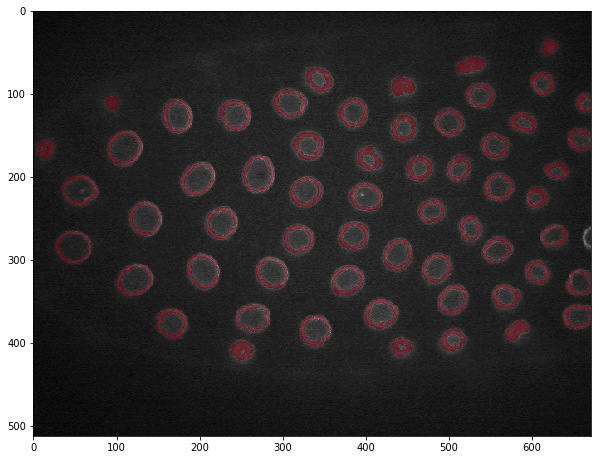

In [110]:
#load the image to process
data = TiffFile(datapath+'Data/30567/30567.tif')
image = data.pages[3].asarray()
#create your mask
nuclei = detect_nuclei(image)
#create a nan-mask for overlay
nuclei_nan = nuclei.copy().astype(float)
nuclei_nan[nuclei == 0] = np.nan

#plot
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.imshow(nuclei_nan, cmap = 'Reds',vmin = 0,vmax = 1,alpha = 0.6)
plt.show()

Let's also remember what was the format of that file (usually one would already know that or verify *e.g.* in Fiji)

In [115]:
data.info()

'TIFF file: 30567.tif, 473 MiB, big endian, ome, 720 pages\n\nSeries 0: 72x2x5x512x672, uint16, TCZYX, 720 pages, not mem-mappable\n\nPage 0: 512x672, uint16, 16 bit, minisblack, raw, ome|contiguous\n* 256 image_width (1H) 672\n* 257 image_length (1H) 512\n* 258 bits_per_sample (1H) 16\n* 259 compression (1H) 1\n* 262 photometric (1H) 1\n* 270 image_description (3320s) b\'<?xml version="1.0" encoding="UTF-8"?><!-- Wa\n* 273 strip_offsets (86I) (182, 8246, 16310, 24374, 32438, 40502, 48566, 56630,\n* 277 samples_per_pixel (1H) 1\n* 278 rows_per_strip (1H) 6\n* 279 strip_byte_counts (86I) (8064, 8064, 8064, 8064, 8064, 8064, 8064, 8064, \n* 282 x_resolution (2I) (1, 1)\n* 283 y_resolution (2I) (1, 1)\n* 296 resolution_unit (1H) 1\n* 305 software (17s) b\'LOCI Bio-Formats\''

On the first line we see that we have 72 time points, 2 colors, 5 planes per color.

The *nuclei* are going to move a bit in Z (perpendicular to the image) over time, so it will be more accurate to segment a projection of the entire stack. So how do we get a complete stack at a given time point. Let's plot the first few images, to understand how they are stored. 

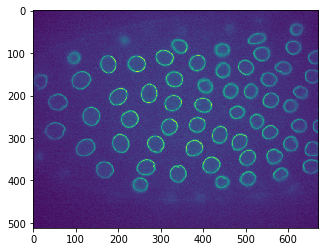

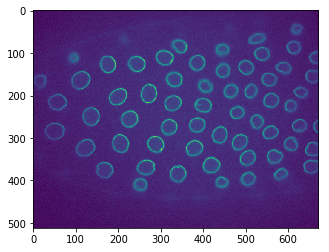

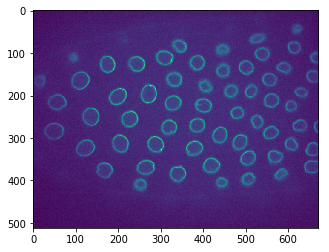

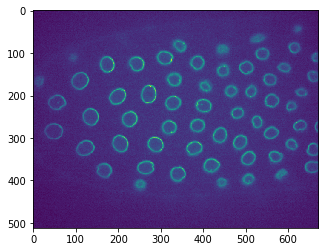

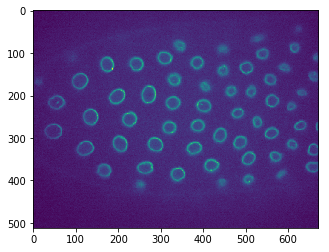

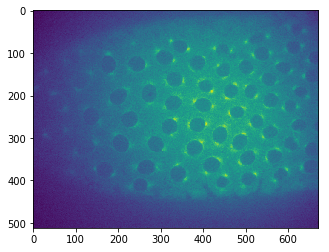

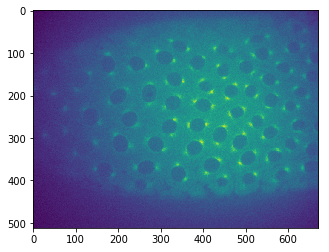

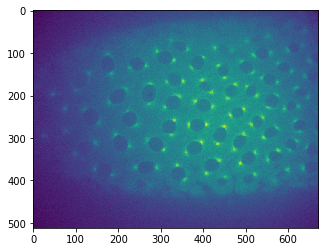

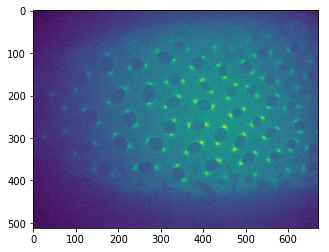

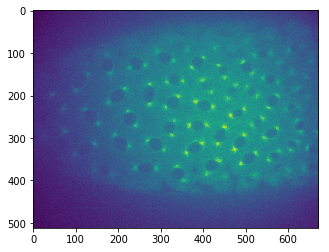

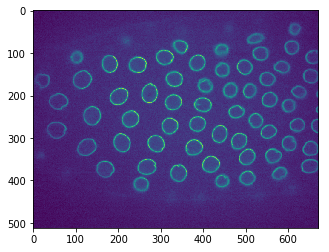

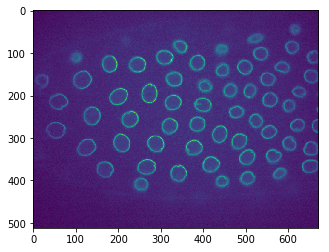

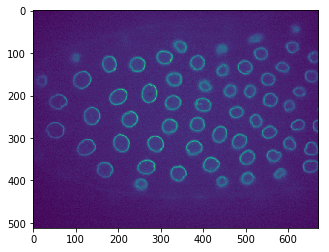

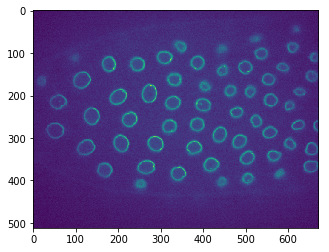

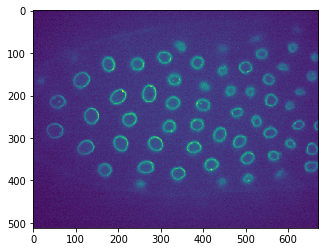

In [117]:
for i in range(15):
    plt.imshow(data.pages[i].asarray())
    plt.show()

## 11.2 Processing a time-lapse

So it looks like we have all planes of colour 1 at time =0, then all planes of color 2 at time =0, then all planes of colour 1 at time = 1 etc... Therefore to get a full stack at a given time we have to use:

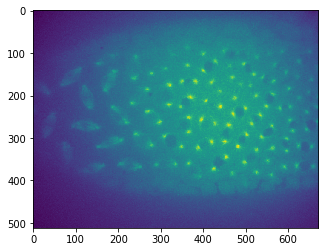

In [200]:
images_per_time = 10
time = 10
color = 1

image_stack = np.stack([x.asarray() 
                        for x in data.pages[time*images_per_time+0+color*5:time*images_per_time+5+color*5]])

plt.imshow(np.max(image_stack, axis = 0))
plt.show()

Let's make a little function out of that:

In [122]:
def get_stack(data, time, color, images_per_time):
    image_stack = np.stack([x.asarray() 
                        for x in data.pages[time*images_per_time+0+color*5:time*images_per_time+5+color*5]])
    return image_stack

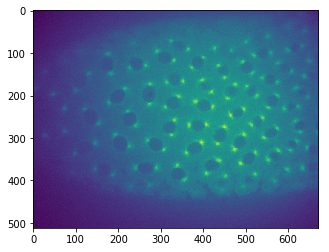

In [125]:
plt.imshow(np.max(get_stack(data, 0, 1, 10), axis = 0))
plt.show()

Now we can chose any time point and segment if using our two functions. In addition we can use the region properties to define the average position of each detected nucleus:

/Users/gw18g940/miniconda3/envs/teaching_test/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 14 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


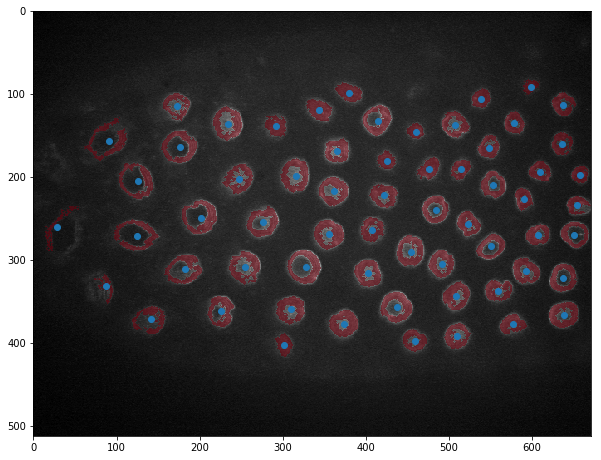

In [130]:
#choose a time
time = 10

#load the stack and segment it
image_stack = get_stack(data, time,0,10)
image = np.max(image_stack, axis = 0)
nuclei = nuclei = detect_nuclei(image)

#find position of nuclei
nuclei_label = label(nuclei)
regions = regionprops(nuclei_label)
centroids = np.array([x.centroid for x in regions])

#create a nan-mask for overlay
nuclei_nan = nuclei.copy().astype(float)
nuclei_nan[nuclei == 0] = np.nan

#plto the result
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.imshow(nuclei_nan, cmap = 'Reds',vmin = 0,vmax = 1,alpha = 0.6)
plt.plot(centroids[:,1], centroids[:,0],'o')
plt.show()

So now we can repeat the same operation for multiple time points and add the array with the coordinates to a list to keep them safe

In [157]:
centroids_time = []
for time in range(10):

    #load the stack and segment it
    image_stack = get_stack(data, time,0,10)
    image = np.max(image_stack, axis = 0)
    nuclei = nuclei = detect_nuclei(image)

    #find position of nuclei
    nuclei_label = label(nuclei)
    regions = regionprops(nuclei_label)
    centroids = np.array([x.centroid for x in regions])
    
    centroids_time.append(centroids)

/Users/gw18g940/miniconda3/envs/teaching_test/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 14 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Let's plot all those centroids for all time points

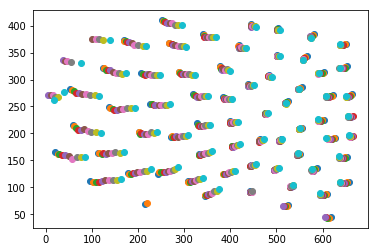

In [134]:
for x in centroids_time:
    plt.plot(x[:,1],x[:,0],'o')
plt.show()

We definitely see tracks corresponding to single nuclei here. How are we going to track them?

## 11.3 Tracking trajectories

The wonderful thing with Python, is that there are a lot of resources that one can just use. For example, if we Google "python tracking", one of the first hits if for the package trackpy which is originally designed to track diffusion particles but can be repurposed for anything.

Browsing through the documentation, we see that we need the function link_df. df stands for dataframe, which is a special data format offered by the package Pandas, and is very close to the R dataframe. Let's load those two modules:

In [136]:
import trackpy
import pandas as pd

And look for some help:

In [138]:
help(trackpy.link_df)

Help on function link in module trackpy.linking.linking:

link(f, search_range, pos_columns=None, t_column='frame', **kwargs)
    link(f, search_range, pos_columns=None, t_column='frame', memory=0,
        predictor=None, adaptive_stop=None, adaptive_step=0.95,
        neighbor_strategy=None, link_strategy=None, dist_func=None,
        to_eucl=None)
    
    Link a DataFrame of coordinates into trajectories.
    
    Parameters
    ----------
    f : DataFrame
        The DataFrame must include any number of column(s) for position and a
        column of frame numbers. By default, 'x' and 'y' are expected for
        position, and 'frame' is expected for frame number. See below for
        options to use custom column names.
    search_range : float or tuple
        the maximum distance features can move between frames,
        optionally per dimension
    pos_columns : list of str, optional
        Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
    t_column : str, 

So we have a lot of options, but the most important thing is to get our data into a dataframe that has three columns, x,y and frame. How are we going to create such a dataframe ? 

### 11.3.1 Pandas dataframe

In [139]:
help(pd.DataFrame)

Help on class DataFrame in module pandas.core.frame:

class DataFrame(pandas.core.generic.NDFrame)
 |  Two-dimensional size-mutable, potentially heterogeneous tabular data
 |  structure with labeled axes (rows and columns). Arithmetic operations
 |  align on both row and column labels. Can be thought of as a dict-like
 |  container for Series objects. The primary pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : numpy ndarray (structured or homogeneous), dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, argument order is maintained for Python 3.6
 |         and later.
 |  
 |  index : Index or array-like
 |      Index to use for resulting frame. Will default to RangeIndex if
 |      no indexing information part of input data and no index provided
 |  columns : Index or array-like
 |      Column labels to use for resulting frame. Will default to
 |      Ran

Tons of information, but basically we can use as input a Numpy array. So let's just try to do that and see what comes out. Our list of coordinates arrays only contains x and y positions but no time. So first we will add a column to each array. Let's test on the first array:

In [158]:
first_array = centroids_time[0].copy()
first_array

array([[ 44.60991736, 617.96859504],
       [ 66.87583893, 525.50503356],
       [ 69.8377193 , 214.86403509],
       [ 84.21711569, 344.35340729],
       [ 87.51840943, 610.23858616],
       [ 92.68029197, 443.62043796],
       [102.70075188, 536.62105263],
       [111.59792285, 308.82492582],
       [110.96569921, 656.40105541],
       [111.90415335,  96.33386581],
       [124.475     , 385.45416667],
       [126.61984733, 177.27022901],
       [125.78917379, 243.28062678],
       [133.64      , 499.15818182],
       [135.22100313, 587.8322884 ],
       [140.68374817, 445.54026354],
       [155.81065089, 652.55621302],
       [163.572843  , 113.85148515],
       [161.8369153 , 332.10872314],
       [162.77382876, 552.24555735],
       [166.1390593 ,  20.28220859],
       [177.10799439, 404.0631136 ],
       [189.30494505, 463.74175824],
       [189.36435331, 511.08359621],
       [193.84693878, 272.60714286],
       [192.45035461, 627.60106383],
       [203.45676998, 201.92822186],
 

We now append a column to this array that contains the time of this frame:

In [159]:
time = 0
first_array = np.c_[first_array, time *np.ones(first_array.shape[0])]
first_array

array([[ 44.60991736, 617.96859504,   0.        ],
       [ 66.87583893, 525.50503356,   0.        ],
       [ 69.8377193 , 214.86403509,   0.        ],
       [ 84.21711569, 344.35340729,   0.        ],
       [ 87.51840943, 610.23858616,   0.        ],
       [ 92.68029197, 443.62043796,   0.        ],
       [102.70075188, 536.62105263,   0.        ],
       [111.59792285, 308.82492582,   0.        ],
       [110.96569921, 656.40105541,   0.        ],
       [111.90415335,  96.33386581,   0.        ],
       [124.475     , 385.45416667,   0.        ],
       [126.61984733, 177.27022901,   0.        ],
       [125.78917379, 243.28062678,   0.        ],
       [133.64      , 499.15818182,   0.        ],
       [135.22100313, 587.8322884 ,   0.        ],
       [140.68374817, 445.54026354,   0.        ],
       [155.81065089, 652.55621302,   0.        ],
       [163.572843  , 113.85148515,   0.        ],
       [161.8369153 , 332.10872314,   0.        ],
       [162.77382876, 552.24555

Let's do the same thing for all time points simply using a comprehension list:

In [162]:
centroids_time2 = [np.c_[x, ind *np.ones(x.shape[0])] for ind, x in enumerate(centroids_time)]
centroids_time2[6]

array([[ 85.31049251, 594.7130621 ,   6.        ],
       [ 90.40891473, 359.75775194,   6.        ],
       [ 91.94095941, 446.11070111,   6.        ],
       [102.04933586, 530.33586338,   6.        ],
       [108.0754717 , 639.55283019,   6.        ],
       [113.77689873, 325.58544304,   6.        ],
       [114.32543103, 136.07543103,   6.        ],
       [128.75271411, 205.30880579,   6.        ],
       [127.97615499, 397.94783905,   6.        ],
       [131.02213001, 269.95988935,   6.        ],
       [132.99843505, 496.70109546,   6.        ],
       [131.38789238, 576.20627803,   6.        ],
       [141.19391635, 447.64638783,   6.        ],
       [153.23333333,  57.32380952,   6.        ],
       [154.34798535, 637.66300366,   6.        ],
       [163.04682779, 142.87613293,   6.        ],
       [161.21509434, 544.10188679,   6.        ],
       [163.30977444, 346.06466165,   6.        ],
       [177.65092402, 410.08829569,   6.        ],
       [186.87563884, 465.84327

Now we can concatenate this list of arrays into one large array that we are then going to transform into a dataframe

In [164]:
centroids_time2 = np.concatenate(centroids_time2)
centroids_time2

array([[ 44.60991736, 617.96859504,   0.        ],
       [ 66.87583893, 525.50503356,   0.        ],
       [ 69.8377193 , 214.86403509,   0.        ],
       ...,
       [392.24482109, 507.03578154,   9.        ],
       [397.68828452, 456.37656904,   9.        ],
       [401.73901099, 294.92582418,   9.        ]])

Let's simply pass that array to Pandas:

In [165]:
pd.DataFrame(coords_time)

,0,1,2
0,44.609917,617.968595,0.0
1,66.875839,525.505034,0.0
2,69.837719,214.864035,0.0
3,84.217116,344.353407,0.0
4,87.518409,610.238586,0.0
5,92.680292,443.620438,0.0
6,102.700752,536.621053,0.0
7,111.597923,308.824926,0.0
8,110.965699,656.401055,0.0
9,111.904153,96.333866,0.0


Not too bad. The x, y and time columns of our arrays are now integrated into a dataframe.

We'd like now to change the headers of our dataframe. In the help we saw that there was on optional field called columns. We can give the appropriate name there:

In [166]:
coords_dataframe = pd.DataFrame(coords_time, columns=('x','y','frame'))
coords_dataframe

,x,y,frame
0,44.609917,617.968595,0.0
1,66.875839,525.505034,0.0
2,69.837719,214.864035,0.0
3,84.217116,344.353407,0.0
4,87.518409,610.238586,0.0
5,92.680292,443.620438,0.0
6,102.700752,536.621053,0.0
7,111.597923,308.824926,0.0
8,110.965699,656.401055,0.0
9,111.904153,96.333866,0.0


That's it! We now have an appropriately formated dataframe to pass to our linking function, which required x,y and frame columns. Information can be retried from dataframes in similar ways as from Numpy arrays or Python dictionaries. For example, one can select a column (the head function limits the output):

In [174]:
tracks['x'].head()

0      44.609917
33    248.584356
34    255.506154
35    260.481848
36    268.189189
Name: x, dtype: float64

One can access a specific row using its index:

In [176]:
tracks.loc[0]

x            44.609917
y           617.968595
frame         0.000000
particle      0.000000
Name: 0, dtype: float64

And one can use logical indexing. For example one can find all the lines corresponding to a given time frame, and extract them:

In [179]:
tracks[tracks['frame']==0].head()

,x,y,frame,particle
0,44.609917,617.968595,0,0
33,248.584356,137.056748,0,1
34,255.506154,227.063077,0,2
35,260.481848,524.721122,0,3
36,268.189189,384.758347,0,4


A dataframe and its contents have also a series of methods attached to them. For example we can get the maximum value from a given columns like this:

In [187]:
tracks['x'].max()

409.8050595238095

Pandas and Numpy are very close, so of course we could also have used the Numpy function:

In [188]:
np.max(tracks['x'])

409.8050595238095

Using the Pandas package would be a course on itself as it is a very powerful tool to handle tabular data. We just showed some very basic features here so that what follows makes sense. Note that this is a situation that occurs often: you just need a few features of a package within a larger project, and have to figure out the basics of it. However, if you work with large tabular data, learning Pandas is highly recommended.

### 11.3.2 Tracking

There are multiple options in the tracking function. *E.g.* in how many frames a signal is allowed to disappear, how we calculate distances between objects *etc.* We are only going to give a value for the fields search_range which specifies in what neighborhood one is doing the tracking.

In [181]:
tracks = trackpy.link_df(coords_dataframe, search_range=20)

Frame 9: 63 trajectories present.


The output is a new dataframe. It contains the position (x,y,frame) of each particle, and to what track (particle) it belongs:

In [183]:
tracks.head()

,x,y,frame,particle
0,44.609917,617.968595,0,0
33,248.584356,137.056748,0,1
34,255.506154,227.063077,0,2
35,260.481848,524.721122,0,3
36,268.189189,384.758347,0,4


We have seen before that we can use indexing. So let's do that to recover all the points forming for example the trajectory = 10

In [186]:
tracks[tracks['particle']==10]

,x,y,frame,particle
42,292.320814,437.802817,0,10
103,290.185759,437.803406,1,10
163,288.868012,438.596273,2,10
225,288.651537,439.784773,3,10
288,288.668721,439.288136,4,10
350,289.728213,440.728213,5,10
413,288.701534,443.525802,6,10
476,288.875000,445.761765,7,10
538,289.774924,448.592145,8,10
600,289.171131,451.400298,9,10


We see that in that particular case, we have one point per frame and the successive points seem close together, so the tracking seems to have worked properly. We can recover all such trajectories and plot them on a single xy plot:

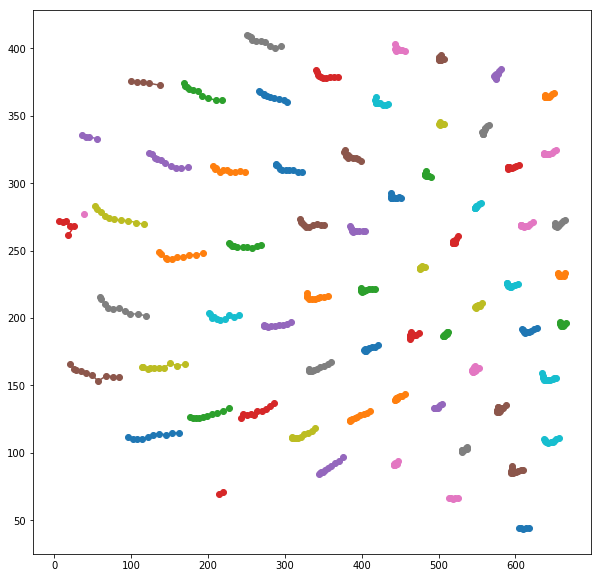

In [192]:
plt.figure(figsize=(10,10))
for particle_id in range(tracks['particle'].max()):
    plt.plot(tracks[tracks.particle==particle_id].y,tracks[tracks.particle==particle_id].x,'o-')
plt.show()

## 11.4 Analysing the data

Now that we have those tracks, we can finally do some quantification of the process. For example we can measure what is the largest distance traveled by each *nucleus*.

In [195]:
msd = trackpy.imsd(tracks,1,1)

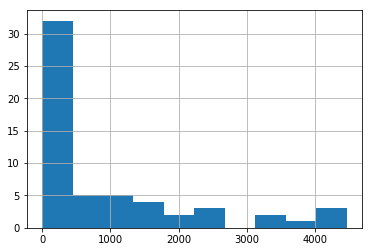

In [197]:
msd.loc[9].hist()

In [245]:
distances = []
for particle_id in range(tracks['particle'].max()):
    #recover current track
    current_track = tracks[tracks.particle==particle_id]
    
    #find beginning and end of track
    min_time = np.min(current_track['frame'])
    max_time = np.max(current_track['frame'])
    
    #get positions at begin and end and measure distance
    x1 = current_track[current_track['frame']==min_time].iloc[0].x
    y1 = current_track[current_track['frame']==min_time].iloc[0].y   
    x2 = current_track[current_track['frame']==max_time].iloc[0].x
    y2 = current_track[current_track['frame']==max_time].iloc[0].y

    distances.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
    

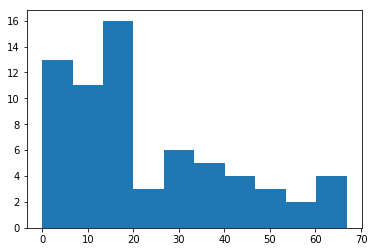

In [246]:
plt.hist(distances)
plt.show()

As we could have guesses from looking at the displacement plot, we have two categories of *nucle*: those that move on the left of the image, and those that don't on the right.